In [73]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time
import sys
from sklearn.svm import SVC
import numpy as np
import nltk
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, precision_score, f1_score, recall_score, roc_auc_score
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import MultinomialNB

In [74]:
# Load the data
data = pd.read_csv('train/train_radiology.csv')
labels = pd.read_csv('train/train_labels.csv')

In [75]:
# Group radiology reports by patient_id and concatenate the text
text = data.groupby('patient_id')['text'].apply(lambda x: ' '.join(x)).reset_index()

In [76]:
# Merge radiology data with label data based on patient_id
data = pd.merge(data, labels, on='patient_id', how='left')

In [77]:
# Tokenization
data['tokenized_text'] = data['text'].apply(lambda x: word_tokenize(x.lower()))

In [78]:
# Data Preprocessing
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

In [79]:
def preprocess_text(tokens):
    tokens = [token for token in tokens if token.isalpha()]  # Remove punctuation
    tokens = [token for token in tokens if token not in stop_words]  # Remove stop words
    tokens = [ps.stem(token) for token in tokens]  # Stemming
    return tokens

In [80]:
data['tokenized_text'] = data['tokenized_text'].apply(preprocess_text)

In [89]:
# Feature Extraction
vectorizer = CountVectorizer(max_features=64)
X = vectorizer.fit_transform(data['tokenized_text'].apply(lambda x: ' '.join(x)))

In [90]:
Y = data['label']

In [91]:
# Split the data into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Evaluate on validation set
val_probs = model.predict_proba(X_val)
val_predictions = (val_probs[:, 1] > 0.5).astype(int)

In [92]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_val, val_predictions)
roc_auc = auc(fpr, tpr)

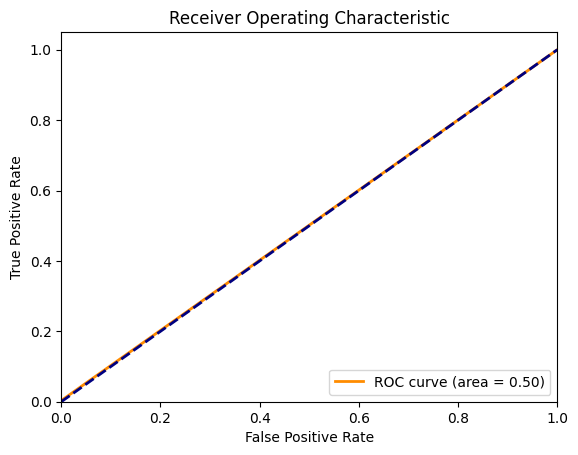

In [93]:
# Plot AUROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [94]:
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation Accuracy:", val_accuracy)

# Get feature importance
feature_importance = model.feature_importances_

# Map feature names to their importance scores
feature_names = vectorizer.get_feature_names_out()
importance_dict = dict(zip(feature_names, feature_importance))

# Sort feature importance dictionary by importance score (descending order)
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print top features
top_features = 10  # Number of top features to display
print(f"Top {top_features} features:")
for feature, importance in sorted_importance[:top_features]:
    print(f"{feature}: {importance}")

Validation Accuracy: 0.8764547896150403
Top 10 features:
right: 0.03543562936345578
left: 0.03156311084369623
tube: 0.023027131273753856
chest: 0.021006040822252308
edema: 0.02100146517068846
lung: 0.020628290752863685
placement: 0.020193377595631265
seen: 0.019882170172328868
chang: 0.019872650490328377
find: 0.01979851099187238
